In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib
from maxvolpy.maxvol import rect_maxvol, maxvol
from sobol_lib import *
from mpl_toolkits.mplot3d import Axes3D
from gen_mat import *
from block_rect_maxvol import *
import re
import os
from matplotlib import cm
from mva_test import *
import itertools
from ipywidgets import interactive, interact, widgets
from scipy.linalg.lapack import get_lapack_funcs
from scipy.linalg import get_blas_funcs
from sympy import *

## General case

In [120]:
def rect_backward_naive(A,n_iters):
    def cold_start_S(C):
        S = np.empty(C.shape[0])
        for i in range(C.shape[0]):
            S[i] = C[i] @ C[i].T
        return(S)
    n, m = A.shape
    ids = np.copy(A[:m])
    C = np.dot(A,np.linalg.pinv(ids))
    S = cold_start_S(C)
    P = np.arange(n)
    non_unique_piv = np.copy(P[:m])
    row_index = m
    for i in range(n_iters):
       
        elem = np.argmax(S)
        print(i)
        ids = np.vstack((ids,A[elem]))

        non_unique_piv = np.hstack((non_unique_piv,P[elem]))

        C = np.dot(A,np.linalg.pinv(ids))
        S = cold_start_S(C)
    
    return(non_unique_piv)

In [121]:
### Full search for D-Optimal submatrix of required shape.
def AllCombsrect(A, num_take_rows=None, debug=False):
    # INPUT 
    # A -- matrix
    # num_take_rows -- required # of rows in a submatrix
    num_of_rows = A.shape[0]
    max_det = 0.0
    good_idx = None
    if num_take_rows is None:
        num_take_rows = A.shape[1] # Take square mat and test square block maxvol
    for i in itertools.combinations(xrange(num_of_rows), num_take_rows):
        Al = A[np.hstack(i)]
        if num_take_rows is None:
            det = np.abs(la.det(Al))
        else:
            det = la.det(np.dot(Al.T,Al))
        if det > max_det:
            max_det = det
            good_idx = i

            
    return(max_det, good_idx) #max_det, good_idx, last_sv, volumes

In [122]:
n_row = 100
n_col = 2
A = np.random.rand(n_row,n_col)
B = np.copy(A)

In [123]:
non_unique_pool = rect_backward_naive(A,n_iters=2000) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


In [124]:
pts,weight = np.unique(non_unique_pool,return_counts=True)

#### Look at weights and estimate cycle length

In [125]:
print(pts)
print(weight)

[ 0  1  5 11 62]
[  1   1 550 748 702]


In [126]:
cyclen = 3

#### Run full search

In [127]:
opt_det,idxs = AllCombsrect(B,num_take_rows = cyclen)

In [128]:
print(idxs)

(5, 11, 62)


#### Compare with pts and feel good :)

## Vandermonde matrices case

I decided to study behavior of a function $\|c\|_2^2 (x)$ in 1D, because it is a crucial parameter by which the greedy algorithm $MaxVol$ works.

Introduce:
$\textbf{x}^T$ = $(1,x,x^2,\ldots, x^k)^T \in \mathbb{R}^{k+1}$, $x \in \mathbb{R}$

$\xi$ --- design, set of points.

$A(\xi) \in \mathbb{R}^{m \times (k+1)}$ --- design matrix built on $m$ support points.

$c^T \in \mathbb{R}^{m}$

$ \textbf{x} = c A \rightarrow c = \textbf{x} A^{+}$


$\|c\|_2^2 = c c^{T} = \textbf{x} A^{+} (A^{+})^T \textbf{x}^T$, denote $A^{+} (A^{+})^T$ as $Q$, and it can be treated as matrix of quadratic form.

$\|c\|_2^2 = \textbf{x} Q \textbf{x}^T = F(x)$

Finally we have a nice polynomial in $x$.

#### Support statement
$Q = (A^T A)^{-1}$

EZ proof:

$Q = A^{+} (A^{+})^T = (A^T A)^{-1}A^T ((A^T A)^{-1}A^T)^T = (A^T A)^{-1} A^T A (A^T A)^{-1})^T = (A^T A)^{-1}$ (Because $Q$ is symmetric matrix) Q.E.D.

In many sources devoted to finding exact D-optimal designs for regression task matrix $Q^{-1} = A^T A = M(\xi)$ is also called information matrix, and function $F(x)$ --- variance of predicted variable.  (Papers which I put in a separate topic in Ryver). It was studied and understood quite well from this point of view. 

More precise, $\|c\|_2^2 = \textbf{x} Q \textbf{x}^T$, and it is not only just second norm of the corresponding row in matrix of coefficients $C$, but also the standardized variance of the predicted response:

$$ \boxed{d(x, \xi) = m  \|c\|_2^2 = m  \textbf{x} M^{-1}(\xi) \textbf{x}^T,} $$
where $m$ is a number of points in the design.

It can be seen that within each step of rect\_maxvol algorithm (expansion of matrix $A$ by 1 row) we have new polynomial, and it has optima on the set of interest. But its structure is changing each time and optima positions change as well. To research this question I derived symbolic maxvol, not to be tied to a discrete mesh.

It makes symbolic derivation and searches for the global maximum on a given domain.

On each iteration it saves added point and quadratic form matrix $Q$ to track how behaviour of $d(x, \xi)$ was changing. Moreover, we can then parse each $Q$ matrix from the $\it{QF\_tensor}$ to get polynomial coefficients.

In [40]:
def QF_parse(QF):   # parse qudratic form matrix to get coefficients within each term
    n = QF.shape[0]
    coeff = np.empty(2*n - 1)
    for i,cft in enumerate(coeff):
        coeff[i] = np.sum(np.diag(QF[::-1],k = i - n + 1))
    return(coeff)

def fx(QF, x):   # calculate variance
    cft = QF_parse(QF)
    power_x = np.array([x**i for i in range(cft.shape[0])])
    return(cft @ power_x) 

def symbolic_maxvol(p_size,poly_type, x_bas, n_iter, x_bounds, save_roots = True):
    QF_tensor = np.empty((p_size, p_size, n_iter))
    xb = np.copy(x_bas)
    x_add = []    
    x = Symbol('x')
    func_list = [x**i for i in range(p_size)]
    func_vec = np.array(func_list)
    roots = []
    
    for i in range(n_iter):
        A_bas = GenMat(p_size, xb, poly=poly_type, debug=False, pow_p=1,ToGenDiff=False)
        
        A_bas_inv = la.pinv(A_bas)
        QF = (A_bas_inv) @ A_bas_inv.T    
        QF_tensor[:,:,i] = QF
        summand = simplify(np.dot(func_vec, QF.dot(func_vec.T)))
        maxs = solve(diff(summand,x,1), x)   ### all zeros of derivative
        #print(maxs)
        
        # complex root filtration
        ind = []
        for j, maxj in enumerate(maxs):
            
            if isinstance(maxj, Add):
                rr = maxj.as_real_imag()
                if rr[1] > np.abs(1*e-15):  ### entry may be of complex type, but imag. part ~ 1e-15, so it's real number
                    print(rr[1])
                    ind.append(j)
                else:
                    maxs[j] = rr[0]
        
        maxs = [y for z, y in enumerate(maxs) if z not in ind]
        #print(maxs)
        if save_roots:
            roots.append(maxs.copy())
            
        maxs.append(x_bounds[0])
        maxs.append(x_bounds[1])
        
        
        
        maxs = np.array(maxs, dtype = float)
        uwu = np.argmax(fx(QF, maxs))
        x_add.append(maxs[uwu])
        xb = np.vstack((xb,maxs[uwu]))

    return(x_add,QF_tensor, roots)       

In [48]:
nder = 1
domain_type = None
p_size = 4 ### number of columns in design matrix
k = 10 ### increase domain borders by k times
n_pts = 100
poly_type = poly_power   ### work with power series for now, as the simplest case
x = complex_area_pnts_gen(n_pts, nder, distrib='lhs', mod = domain_type)*k
x_bounds = np.array([[-1*k],
                      [k]])
x = np.vstack((x, x_bounds))

In [81]:
### let initial design be just first p_size entries of x

x_bas  = np.copy(x[:p_size])

n_iters = 200

In [82]:
added_pts, QFtS, rts = symbolic_maxvol(p_size,poly_type,x_bas, n_iters,x_bounds)

Once we have tensor of all $Q$ matrices from each iteration, we can have a look on how our $\|c\|_2^2 = d(x, \xi)$ evolutes under change of the design matrix.

For example:

In [83]:
xt = np.linspace(x_bounds[0],x_bounds[1], 10000)

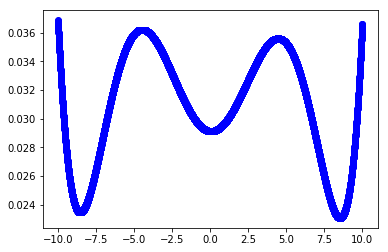

In [90]:
plt.plot(xt,fx(QFtS[:,:,107],xt),'bo')

# The sweetest thing

The General Equivalence Theorem (Kiefer, J. C. and Wolfowitz, J, 1960) states that for D-optimal design:

Design $\xi ^{\ast}$ minimizes $(- \log \det M(\xi))	\Leftrightarrow  d(x, \xi ^{\ast}) \leq (k+1)$, where $k+1$ term is a number of columns aka basis functions.

Papers concerning exact D-optimal designs use this theorem to test if obtained design is a globally optimal one.

We want to achieve:
$$\frac{d(x, \xi ^{\ast})}{m} = \|c\|_2^2 (x) \leq \frac{(k+1)}{m}$$

Let us take last unique points:

In [91]:
design = added_pts[-4:]

In [92]:
design

[10.0, -4.475972209375723, 4.466601485776426, -10.0]

In [93]:
design = np.array(design).reshape(len(design),1)

The last points where symbolic maxvol converged.

In [99]:
A_bas = GenMat(p_size, design, poly=poly_type, debug=False, pow_p=1,ToGenDiff=False)
k = A_bas.shape[1]
        
A_bas_inv = la.pinv(A_bas)
Q = (A_bas_inv) @ A_bas_inv.T ### Form matrix of quadratic form

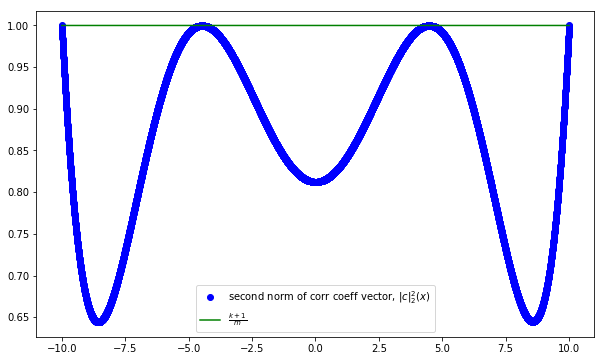

In [129]:
fig = plt.figure(figsize=(10,6))


plt.plot(xt,fx(Q,xt),'bo', label=r'second norm of corr coeff vector, $\|c\|_2^2 (x)$')

plt.plot(xt, np.ones(xt.shape[0])*(k/design.shape[0]),'g', label=r'$\frac{k+1}{m}$')
plt.legend()

So we can see that our support points satisfy the conditions of the theorem, and therefore form a D-optimal design on a set of interest.

In case of discrete maxvol let us introduce 'mesh density' $d = min(|x_i - x_j|),\quad \forall i,j : i \neq j$

Once optima positions $\delta x_{opt}$ changes such as $\delta x_{opt} < d$ we will get repetition (or clustering) in the discrete case. And that's all about this 'magical' clustering.